In [ ]:
from google.colab import drive
drive.mount('/content/drive')\

file_path = '/content/drive/My Drive/EC ENGR 219 Large-Scale Data Mining: Models & Algorithms/Project 2/Steam Game Review - Datasets/main.csv'

import pandas as pd
df_review = pd.read_csv(file_path)
df_review.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,user,playtime,post_date,helpfulness,review_text,recommend,early_access_review,appid,game_name,release_date,genres
0,Pakistan warrior,47.8,"November 3, 2023",3911,ALT + F4 best feature in the game 10/10,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
1,Zuvi,1969.8,"November 2, 2022",3154,"SPAWN DIE, SPAWN DIE, SPAWN DIE, SPAWN DIE.-Jev",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
2,SƎXSƎN,1190.7,"August 5, 2023",2821,"My wife said if this review gets 100 likes, I ...",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
3,Lunación,482.2,"November 10, 2023",2530,"Nobody will read my review, so I'll just say I...",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action
4,Max,3.4,"July 11, 2024",2320,Nobody will read my review so i will do 1 push...,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action


In [ ]:
# Task 1 - Unsupervised Review Length Discovery
# • Reviews in the top 25% (≥ q75) by length are labeled as Long,
# • Reviews in the bottom 25% (≤ q25) by length are labeled as Short,
# • Reviews in the middle 50% are discarded for this task.

# QUESTION 1: Report the number of reviews retained after filtering, and the average length (in tokens) of Short and Long reviews.
# Ans: 20497 reviews (after filtering); 493.0 average words for Long reviews, 6.4 average words for Short reviews

import numpy as np

df_review['review_length'] = df_review['review_text'].str.split().str.len()

q25 = df_review['review_length'].quantile(0.25) # 11.0
q75 = df_review['review_length'].quantile(0.75) # 179.0

print(q25, q75)

conditions = [
    df_review['review_length'] >= q75,
    df_review['review_length'] <= q25
]

df_review['review_length_type'] = np.select(conditions, ['Long', 'Short'], default='Discarded')

df_review_clean = df_review[df_review['review_length_type'] != 'Discarded']

display(df_review_clean.head())

print(f'Number of reviews, after filtering: {len(df_review_clean)}')
print(f'Average word length of Long reviews: {df_review_clean['review_length'][df_review_clean['review_length_type']=='Long'].mean()}')
print(f'Average word length of Short reviews: {df_review_clean['review_length'][df_review_clean['review_length_type']=='Short'].mean()}')

11.0 179.0


,user,playtime,post_date,helpfulness,review_text,recommend,early_access_review,appid,game_name,release_date,genres,review_length,review_length_type
0,Pakistan warrior,47.8,"November 3, 2023",3911,ALT + F4 best feature in the game 10/10,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,9,Short
1,Zuvi,1969.8,"November 2, 2022",3154,"SPAWN DIE, SPAWN DIE, SPAWN DIE, SPAWN DIE.-Jev",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,8,Short
3,Lunación,482.2,"November 10, 2023",2530,"Nobody will read my review, so I'll just say I...",True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,11,Short
5,ORION,1165.6,"December 10, 2022",2245,Crash Of Duty : Update Requires Restart,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,7,Short
6,Bandy,1723.2,"October 29, 2022",2001,update requires restart,True,NaN,1938090,Call of Duty®,"Oct 27, 2022",Action,3,Short


Number of reviews, after filtering: 20497
Average word length of Long reviews: 493.00209288419376
Average word length of Short reviews: 6.391474720443467


In [ ]:
# QUESTION 2: Report the dimensions of the TF-IDF matrix and the MiniLM embedding matrix.
# Briefly explain why TF-IDF is sparse while MiniLM embeddings are dense.

# Ans: TF-IDF matrix size: (20497, 25085), MiniLM embedding matrix size: (20497, 384)
# Also, TF-IDF is sparse because the feature dimensions comprise words obtained from the aggregated vocabulary of all review texts (25,085 words),
# where for a single review, this will only contain a small proportion of words, leaving most dimensions as zero.
# However for MiniLM, this uses a neural network to encode the review's semnatic meaning into a fixed 384-dimensional space,
# producing non-zero values in a dense vector embedding.

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# 1. TF-IDF representation
print("Creating TF-IDF representation...")
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,             # only include words that appear in at least 3 reviews
    stop_words='english',
    ngram_range=(1, 1)    # min. one word, max. one word
)
X_tfidf = tfidf_vectorizer.fit_transform(df_review_clean['review_text']) # Fit and transform the review texts
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

# 2. MiniLM embeddings
print("\nCreating MiniLM embeddings...")
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}") # Check model embedding dimension
X_minilm = model.encode(
    df_review_clean['review_text'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f"MiniLM embedding matrix shape: {X_minilm.shape}")

Creating TF-IDF representation...
TF-IDF matrix shape: (20497, 25085)

Creating MiniLM embeddings...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding dimension: 384


Batches:   0%|          | 0/641 [00:00<?, ?it/s]

MiniLM embedding matrix shape: (20497, 384)


In [ ]:
# QUESTION 3: For each pipeline, report the following clustering agreement metrics with respect
# to the ground-truth length labels: homogeneity, completeness, v-measure, ARI, AMI.
# Summarize results in a table and identify the best-performing pipeline.

# Ans: See results table below.
# Best score for Homogeneity: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
# Best score for Completeness: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
# Best score for V-Measure: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
# Best score for ARI: 0.862 is from MiniLM + SVD(50) + Agglomerative (n=2)
# Best score for AMI: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)

from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score,
    adjusted_rand_score,
    adjusted_mutual_info_score
)
from sklearn.neighbors import kneighbors_graph
import warnings
warnings.filterwarnings('ignore')

# Get ground truth labels, and map: Short=0, Long=1
y_true = df_review_clean['review_length_type'].values
label_map = {'Short': 0, 'Long': 1}
y_true_binary = np.array([label_map[label] for label in y_true])

print(f'Total samples: {len(y_true_binary)}')
print(f'Short reviews: {np.sum(y_true_binary == 0)}')
print(f'Long reviews: {np.sum(y_true_binary == 1)}')

def evaluate_clustering(y_true, y_pred, pipeline):
    """Calculate all clustering metrics used to evaluate each pipeline"""
    metrics = {
        'Pipeline': pipeline,
        'Homogeneity': homogeneity_score(y_true, y_pred),
        'Completeness': completeness_score(y_true, y_pred),
        'V-Measure': v_measure_score(y_true, y_pred),
        'ARI': adjusted_rand_score(y_true, y_pred),
        'AMI': adjusted_mutual_info_score(y_true, y_pred)
    }
    return metrics

# Store all results in this list
results = []

Total samples: 20497
Short reviews: 10463
Long reviews: 10034


In [ ]:
# TF-IDF CLUSTERING PIPELINES

# # 1. TF-IDF + No Dimensionality Reduction + K-Means (k=2)
# try:
#     kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
#     y_pred = kmeans.fit_predict(X_tfidf)
#     results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + No Dimensionality Reduction + K-Means (k=2)'))
# except Exception as e:
#     print(f"{e}; TF-IDF matrix is likely too large and sparse for efficient computation")

# # 2. TF-IDF + No Dimensionality Reduction + Agglomerative (n=2)
# try:
#     agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
#     y_pred = agg.fit_predict(X_tfidf.toarray()) # conversion from sparse to dense input first
#     results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + No Dimensionality Reduction + Agglomerative (n=2)'))
# except Exception as e:
#     print(f"{e}; agglomerative clustering requires dense input (not sparse); conversion requires high RAM")

# 3. TF-IDF + SVD(50) + K-Means (k=2)
svd_tfidf = TruncatedSVD(n_components=50, random_state=1)
X_tfidf_svd = svd_tfidf.fit_transform(X_tfidf)
print(f"Reduced matrix shape: {X_tfidf_svd.shape}")
kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_tfidf_svd)
results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + SVD(50) + K-Means (k=2)'))

# 4. TF-IDF + SVD(50) + Agglomerative (n=2)
conn = kneighbors_graph(X_tfidf_svd, n_neighbors=10, mode='connectivity', include_self=False) # each point to consider 10 nearest neighbours
agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)                # leverage connectivity for faster computation
y_pred = agg.fit_predict(X_tfidf_svd)
results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + SVD(50) + Agglomerative (n=2)'))

# # 5. TF-IDF + SVD(200) + UMAP(50) + K-Means (k=2)
# svd_pre = TruncatedSVD(n_components=200, random_state=1)
# X_tfidf_svd200 = svd_pre.fit_transform(X_tfidf)
# umap_tfidf = UMAP(n_components=50, random_state=1, n_neighbors=15, min_dist=0.1)
# X_tfidf_umap = umap_tfidf.fit_transform(X_tfidf_svd200)
# print(f"Reduced matrix shape: {X_tfidf_umap.shape}")
# kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
# y_pred = kmeans.fit_predict(X_tfidf_umap)
# results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + SVD(200) + UMAP(50) + K-Means (k=2)'))

# # 6. TF-IDF + UMAP(50) + Agglomerative (n=2)
# conn = kneighbors_graph(X_tfidf_umap, n_neighbors=10, mode='connectivity', include_self=False)
# agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)
# y_pred = agg.fit_predict(X_tfidf_umap)
# results.append(evaluate_clustering(y_true_binary, y_pred, 'TF-IDF + UMAP(50) + Agglomerative (n=2)'))

Reduced matrix shape: (20497, 50)


In [ ]:
# MiniLM PIPELINES

# 1. MiniLM + No Dimensionality Reduction + K-Means (k=2)
kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + No Dimensionality Reduction + K-Means (k=2)'))

# 2. MiniLM + No Dimensionality Reduction + Agglomerative (n=2)
conn = kneighbors_graph(X_minilm, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + No Dimensionality Reduction + Agglomerative (n=2)'))

# 3. MiniLM + SVD(50) + K-Means (k=2)
svd_minilm = TruncatedSVD(n_components=50, random_state=1)
X_minilm_svd = svd_minilm.fit_transform(X_minilm)
print(f"Reduced matrix shape: {X_minilm_svd.shape}")
kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm_svd)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + SVD(50) + K-Means (k=2)'))

# 4. MiniLM + SVD(50) + Agglomerative (n=2)
conn = kneighbors_graph(X_minilm_svd, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm_svd)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + SVD(50) + Agglomerative (n=2)'))

# 5. MiniLM + UMAP(50) + K-Means (k=2)
umap_minilm = UMAP(n_components=50, random_state=1, n_neighbors=15, min_dist=0.1)
X_minilm_umap = umap_minilm.fit_transform(X_minilm)
print(f"Reduced shape: {X_minilm_umap.shape}")
kmeans = KMeans(n_clusters=2, random_state=1, n_init=10)
y_pred = kmeans.fit_predict(X_minilm_umap)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + UMAP(50) + K-Means (k=2)'))

# 6. MiniLM + UMAP(50) + Agglomerative (n=2)
conn = kneighbors_graph(X_minilm_umap, n_neighbors=10, mode='connectivity', include_self=False)
agg = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn)
y_pred = agg.fit_predict(X_minilm_umap)
results.append(evaluate_clustering(y_true_binary, y_pred, 'MiniLM + UMAP(50) + Agglomerative (n=2)'))


Reduced matrix shape: (20497, 50)
Reduced shape: (20497, 50)


In [ ]:
# Prepare results table
results_df = pd.DataFrame(results)
metric_cols = ['Homogeneity', 'Completeness', 'V-Measure', 'ARI', 'AMI']
results_df[metric_cols] = results_df[metric_cols].round(3)

display(results_df)

for metric in metric_cols:
    best_idx = results_df[metric].idxmax()
    best_pipeline = results_df.loc[best_idx, 'Pipeline']
    best_score = results_df.loc[best_idx, metric]
    print(f"Best score for {metric}: {best_score:.3f} is from {best_pipeline}")

,Pipeline,Homogeneity,Completeness,V-Measure,ARI,AMI
0,TF-IDF + SVD(50) + K-Means (k=2),0.030,0.161,0.051,0.006,0.051
1,TF-IDF + SVD(50) + Agglomerative (n=2),0.036,0.168,0.059,0.008,0.059
2,MiniLM + No Dimensionality Reduction + K-Means...,0.510,0.510,0.510,0.614,0.510
3,MiniLM + No Dimensionality Reduction + Agglome...,0.532,0.534,0.533,0.637,0.533
4,MiniLM + SVD(50) + K-Means (k=2),0.511,0.511,0.511,0.615,0.511
5,MiniLM + SVD(50) + Agglomerative (n=2),0.777,0.777,0.777,0.862,0.777
6,MiniLM + UMAP(50) + K-Means (k=2),0.034,0.158,0.056,0.007,0.056
7,MiniLM + UMAP(50) + Agglomerative (n=2),0.034,0.158,0.056,0.007,0.056


Best score for Homogeneity: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
Best score for Completeness: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
Best score for V-Measure: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)
Best score for ARI: 0.862 is from MiniLM + SVD(50) + Agglomerative (n=2)
Best score for AMI: 0.777 is from MiniLM + SVD(50) + Agglomerative (n=2)


In [ ]:
# QUESTION 4: Compare TF-IDF and MiniLM performance on this task.
# Which representation separates Short vs Long reviews more cleanly, and why?

# Answer:
# MiniLM is able to separate Short vs Long reviews more cleanly than TF-IDF.

# Best performing pipeline (MiniLM + SVD(50) + Agglomerative (n=2) achieves a # V-Measure of 0.777,
# compared to TF-IDF's best performance of 0.059: TF-IDF + SVD(50) + Agglomerative (n=2)

# This is becuase:
# 1. Dense vs sparse representations
# TF-IDF loses information during SVD (length information relies on its sparse representation with multiple zero entries);
# however when compressed to 50 dimensions, the sparse signal becomes overly diluted.
# This is in comparison to MiniLM, which begins with a dense embedding (384 non-zero values),
# preserving rich distribution of information even after dimensionality reduction.

# 2. Semantic interpretation
# MiniLM is a Neural Network that considers a richer representation of the data, including context, semantic meaning and syntactic features;
# MiniLM could also pick up linguistic differences that occur with longer (e.g. complex sentence structure, or detailed descriptor words) vs. shorter review length.
# Whereas, TF-IDF considers primarily term frequency with respect to different review documents.

# 3. UMAP signal dilution
# Also, UMAP dimensionality reduction for MiniLM appears to weaken the length-based separation (V-Measure: 0.056),
# as UMAP relies on local neighbourhood structure to place semantically similar reviews close together (i.e. positive reviews clustered together).

In [ ]:
# QUESTION 5: Plots and Visualization: Select the best-performing configuration for TF–IDF
# and MiniLM based on clustering performance. For each representation:

# • Reduce the embeddings to two dimensions using PCA (sklearn.decomposition.PCA).
# • Create a split visualization with:
# – One plot colored by the ground-truth length label.
# – One plot colored by the cluster assignments obtained using your best clustering method.

# The resulting plots should enable a direct visual comparison between the true labels and the
# discovered clusters for both TF–IDF and MiniLM representations, highlighting how well each
# representation supports unsupervised separation.

TF-IDF PCA dimension reduction: (20497, 50) -> (20497, 2)
MiniLM PCA dimension reduction: (20497, 50) -> (20497, 2)


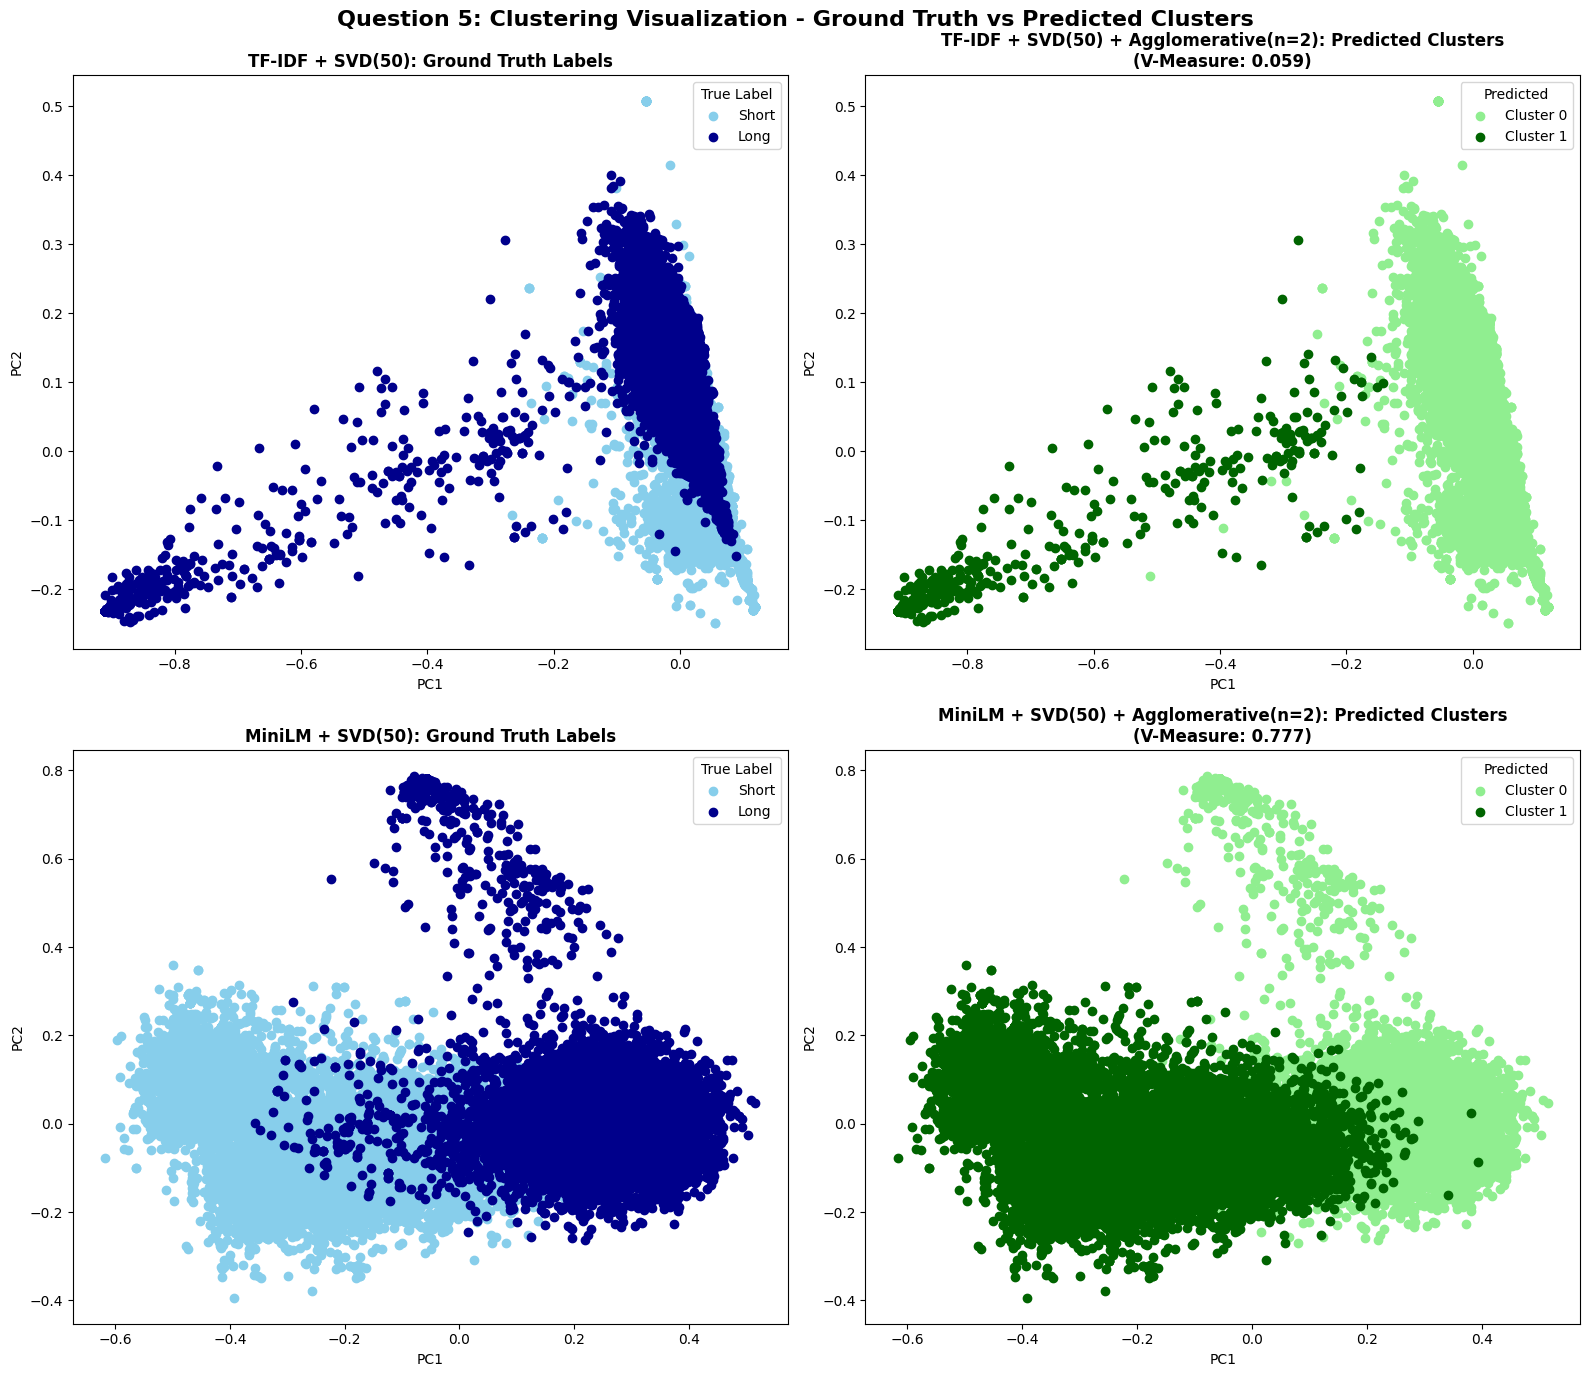

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# TF-IDF + SVD(50) + Agglomerative (n=2)
conn_tfidf = kneighbors_graph(X_tfidf_svd, n_neighbors=10, mode='connectivity', include_self=False)
agg_tfidf = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn_tfidf)
y_pred_tfidf_best = agg_tfidf.fit_predict(X_tfidf_svd)

pca_tfidf = PCA(n_components=2, random_state=1)
X_tfidf_2d = pca_tfidf.fit_transform(X_tfidf_svd)
print(f"TF-IDF PCA dimension reduction: {X_tfidf_svd.shape} -> {X_tfidf_2d.shape}") # Represents review representation as a 2d-coordinate for plotting

# MiniLM + SVD(50) + Agglomerative (n=2)
conn_minilm = kneighbors_graph(X_minilm_svd, n_neighbors=10, mode='connectivity', include_self=False)
agg_minilm = AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=conn_minilm)
y_pred_minilm_best = agg_minilm.fit_predict(X_minilm_svd)

pca_minilm = PCA(n_components=2, random_state=1)
X_minilm_2d = pca_minilm.fit_transform(X_minilm_svd)
print(f"MiniLM PCA dimension reduction: {X_minilm_svd.shape} -> {X_minilm_2d.shape}") # Represents review embedding as a 2d-coordinate for plotting

# Initialise visualisation
true_colors = {0: '#87CEEB', 1: '#00008B'}  # Short    : Light Blue,  Long     : Dark Blue
pred_colors = {0: '#90EE90', 1: '#006400'}  # Cluster 0: Light Green, Cluster 1: Dark Green

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle(
    'Question 5: Clustering Visualization - Ground Truth vs Predicted Clusters',
    fontsize=16, fontweight='bold'
)

# ============================================================================
# TF-IDF Visualizations
# ============================================================================

# TF-IDF: Ground Truth
ax1 = axes[0, 0]
for label in [0, 1]:
    mask = y_true_binary == label
    label_name = 'Short' if label == 0 else 'Long'
    ax1.scatter(X_tfidf_2d[mask, 0], X_tfidf_2d[mask, 1],
               c=true_colors[label], label=label_name)
ax1.set_title('TF-IDF + SVD(50): Ground Truth Labels', fontsize=12, fontweight='bold')
ax1.set_xlabel(f'PC1', fontsize=10)
ax1.set_ylabel(f'PC2', fontsize=10)
ax1.legend(title='True Label', loc='best')

# TF-IDF: Predicted Clusters
ax2 = axes[0, 1]
for cluster in [0, 1]:
    mask = y_pred_tfidf_best == cluster
    ax2.scatter(X_tfidf_2d[mask, 0], X_tfidf_2d[mask, 1],
               c=pred_colors[cluster], label=f'Cluster {cluster}')#,
               #alpha=0.6, s=30, edgecolors='black', linewidth=0.3)

ax2.set_title(f'TF-IDF + SVD(50) + Agglomerative(n=2): Predicted Clusters\n(V-Measure: 0.059)', fontsize=12, fontweight='bold')
ax2.set_xlabel(f'PC1', fontsize=10)
ax2.set_ylabel(f'PC2', fontsize=10)
ax2.legend(title='Predicted', loc='best')

# ============================================================================
# MiniLM Visualizations
# ============================================================================

# MiniLM: Ground Truth
ax3 = axes[1, 0]
for label in [0, 1]:
    mask = y_true_binary == label
    label_name = 'Short' if label == 0 else 'Long'
    ax3.scatter(X_minilm_2d[mask, 0], X_minilm_2d[mask, 1],
               c=true_colors[label], label=label_name)

ax3.set_title('MiniLM + SVD(50): Ground Truth Labels', fontsize=12, fontweight='bold')
ax3.set_xlabel(f'PC1', fontsize=10)
ax3.set_ylabel(f'PC2', fontsize=10)
ax3.legend(title='True Label', loc='best')

# MiniLM: Predicted Clusters
ax4 = axes[1, 1]
for cluster in [0, 1]:
    mask = y_pred_minilm_best == cluster
    ax4.scatter(X_minilm_2d[mask, 0], X_minilm_2d[mask, 1],
               c=pred_colors[cluster], label=f'Cluster {cluster}')

ax4.set_title(f'MiniLM + SVD(50) + Agglomerative(n=2): Predicted Clusters\n(V-Measure: 0.777)', fontsize=12, fontweight='bold')
ax4.set_xlabel(f'PC1', fontsize=10)
ax4.set_ylabel(f'PC2', fontsize=10)
ax4.legend(title='Predicted', loc='best')

plt.tight_layout()
plt.show()

In [ ]:
# Task 2 - Unsupervised Game Similarity & Genre Structure

# QUESTION 6: Report the dimensions of the TF-IDF game matrix and the MiniLM game embedding matrix
# Ans:  TF-IDF matrix size: (200, 16554), MiniLM embedding matrix size: (200, 384)

df_review_positive = df_review[df_review['recommend'] == True]
df_review_by_game = df_review_positive.groupby('game_name')['review_text'].apply(
    lambda reviews: ' '.join(reviews)
).reset_index()
df_review_by_game.columns = ['game_name', 'review_text_concat']


from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# 1. TF-IDF representation
print("Creating TF-IDF representation...")
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,             # only include words that appear in at least 3 reviews
    stop_words='english',
    ngram_range=(1, 1)    # min. one word, max. one word
)
X_tfidf_positive = tfidf_vectorizer.fit_transform(df_review_by_game['review_text_concat']) # Fit and transform the review texts
print(f"TF-IDF matrix shape: {X_tfidf_positive.shape}")

# 2. MiniLM embeddings
print("\nCreating MiniLM embeddings...")
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}") # Check model embedding dimension
X_minilm_positive = model.encode(
    df_review_by_game['review_text_concat'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f"MiniLM embedding matrix shape: {X_minilm_positive.shape}")

Creating TF-IDF representation...
TF-IDF matrix shape: (200, 16554)

Creating MiniLM embeddings...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding dimension: 384


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

MiniLM embedding matrix shape: (200, 384)


In [ ]:
# QUESTION 7: For each pipeline, report a summary table that includes:
# • number of clusters found (for HDBSCAN, also report the fraction of games labeled as noise -1),
# • cluster sizes,
# • for each cluster: top 3 most common genres (by frequency across games in that cluster).

In [ ]:
# QUESTION 8: Pick one best pipeline (justify your choice), then report two cluster with high purity:
# • top 3 genres with percentages,
# • cluster genre purity (as defined above),
# • Representative games in the cluster (game name + genres).
# Provide a short interpretation: what type of games does these clusters represent?